# Clasificación de Imágenes de Cáncer de Mama con Redes Neuronales Convolucionales

# Objetivos del Proyecto
Desarrollar una red neuronal convolucional (CNN) para clasificar imágenes


1.   Desarrollar una red neuronal convolucional (CNN) para clasificar imágenes histológicas de tejido mamario en categorías de cáncer benigno o maligno
2. Entrenar el modelo en un conjunto de datos de imágenes médicas de alta calidad.
3. Evaluar el rendimiento del modelo en términos de precisión, sensibilidad, especificidad y matriz de confusión.
4. Realizar predicciones sobre un conjunto de imágenes nuevas y analizar los resultados.

# Dataset
Para este proyecto, se utilizó el dataset Breast Cancer Histopathology Images de TensorFlow, El cual se encuentra en la siguiente URL:https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images. Este dataset contiene imágenes de biopsias de mama con etiquetas que indican si el tejido es maligno o benigno.

# Importacion de Librerias

In [26]:
# Importar librerías
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Import ImageDataGenerator explicitly
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras.saving

# Cargar y procesar el dataset

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


Contenido del directorio del dataset: ['9290', '10306', '10293', '9226', '13460', '13666', '9261', '13459', '10288', '13019', '13693', '15472', '10290', '16533', '10274', '16167', '10261', '12817', '14213', '10277', '9043', '9319', '15473', '10305', '12749', '12241', '12933', '12890', '12931', '13403', '9382', '12877', '13617', '15514', '8917', '16551', '8864', '12949', '12930', '14190', '15512', '8955', '14188', '10269', '13024', '14079', '12822', '14157', '9022', '10268', '9076', '9347', '13689', '15510', '13400', '12935', '9075', '12750', '9324', '12955', '12911', '14189', '10259', '12881', '12908', '9346', '10307', '9023', '12879', '12895', '9135', '12909', '8959', '13106', '12878', '10292', '16165', '12947', '10256', '12871', '10282', '16555', '10279', '16550', '10285', '12893', '9227', '9173', '14081', '10254', '12811', '12901', '9262', '14306', '12242', '8980', '16532', '12876', '12880', '16534', '9037', '12823', '9291', '15632', '12886', '10291', '10286', '12821', '12868', '926

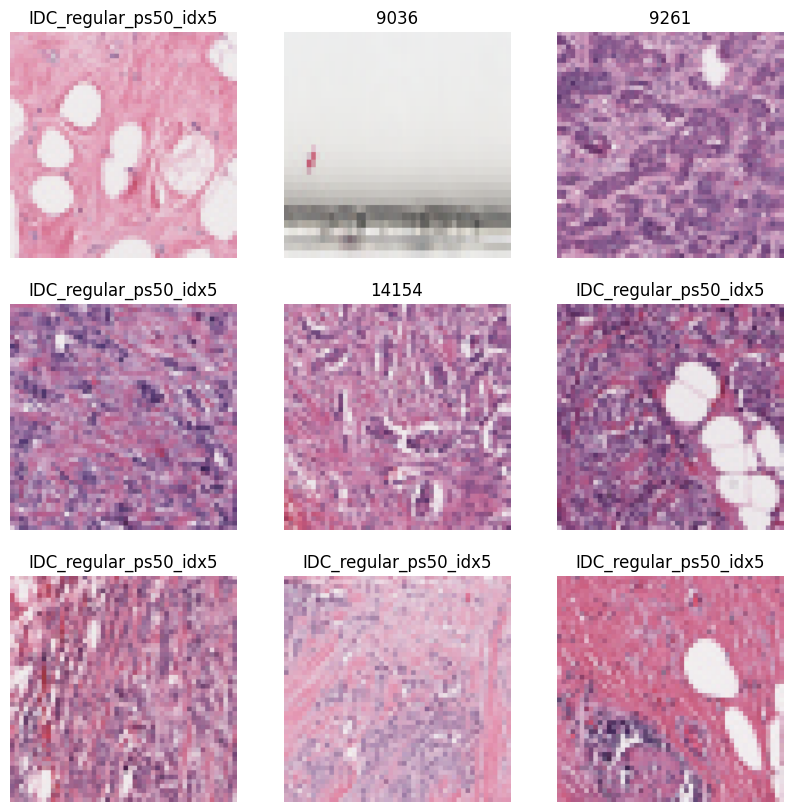

In [28]:
# Ruta del dataset
dataset_dir = path  # Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1

# Verifica si el dataset contiene subcarpetas 'benign' y 'malignant'
print("Contenido del directorio del dataset:", os.listdir(dataset_dir))

# Carga y procesamiento de imágenes
batch_size = 32
img_height = 150
img_width = 150

# Configuración del generador de datos de entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # Utilizamos el 20% de los datos para validación
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Generador de validación
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Mostrar algunas imágenes del dataset
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    break  # Mostrar solo una tanda de imágenes
plt.show()


# Configurar el rendimiento del dataset
Este paso es indispensable, debido a que permite optimizar la carga y procesamientp de datos durante el entrenamiento del modelo

In [4]:
AUTOTUNE = tf.data.AUTOTUNE  # TensorFlow determina automáticamente el valor óptimo

# Convertir el generador en tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Optimización del rendimiento
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Crear la red convolucional
Para este modelo se construyó una CNN simple con capas de convolución y de pooling, terminando con una capa densa para la clasificación.

In [5]:
# Definir el modelo CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Mostrar el resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Dado que los recursos disponibles en Google Colab no son suficientes para procesar la cantidad de imágenes necesarias, se ha decidido adquirir la versión paga para ejecutar el modelo de manera exitosa. A continuación, se muestran las líneas de código que evidencian la capacidad de la máquina utilizada

In [6]:
!nvidia-smi

Thu Nov 14 20:14:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              32W /  70W |    619MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 14 20:14:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              32W /  70W |    619MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

El siguiente fragmento de código verifica si hay una GPU disponible en el entorno de ejecución y, en caso afirmativo, habilita la ejecución en la GPU. La GPU Permite procesar grandes cantidades de datos, conjuntos de imágenes voluminosos ymanejar las operaciones de cálculo de forma mucho más eficiente que una CPU.

A continuación, se muestra el código utilizado para comprobar la disponibilidad de la GPU y ejecutar las operaciones en ella

In [8]:
import tensorflow as tf

# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
  print("GPU disponible. Habilitando la ejecución en GPU.")
  # Habilitar la ejecución en GPU
  with tf.device('/GPU:0'):
    # This block was missing before, causing the error
    # Add the code that should be executed on the GPU here.
    print("Ejecutando en GPU.")  # Example: Print a message
    # ... your code using the GPU goes here ...
else:
  print("No se encontró una GPU. La ejecución se realizará en CPU.")

GPU disponible. Habilitando la ejecución en GPU.
Ejecutando en GPU.


# Compilar y entrenar el modelo
Para este modelo se utiliza el optimizador Adam el cual es eficiente para entrenar redes neuronales profundas. Este optimizador adapta las tasas de aprendizaje para cada parámetro de manera individual, lo que le permite converger más rápido y de manera más estable. Asi mismo, se empleó la función de pérdida y métricas de evaluación para medir el rendimiento del modelo durante el entrenamiento.

In [9]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13880/13880 ━━━━━━━━━━━━━━━━━━━━ 410s 29ms/step - accuracy: 0.0015 - loss: -742790930703702818816.0000 - val_accuracy: 0.0015 - val_loss: -17351490036431276998656.0000
Epoch 2/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 392s 28ms/step - accuracy: 0.0013 - loss: nan - val_accuracy: 9.8286e-04 - val_loss: nan
Epoch 3/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 383s 28ms/step - accuracy: 0.0010 - loss: nan - val_accuracy: 9.8286e-04 - val_loss: nan
Epoch 4/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 381s 27ms/step - accuracy: 0.0010 - loss: nan - val_accuracy: 9.8286e-04 - val_loss: nan
Epoch 5/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 388s 28ms/step - accuracy: 9.7282e-04 - loss: nan - val_accuracy: 9.8286e-04 - val_loss: nan
Epoch 6/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 387s 28ms/step - accuracy: 0.0010 - loss: nan - val_accuracy: 9.8286e-04 - val_loss: nan
Epoch 7/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 382s 28ms/step - accuracy: 9.4033e-04 - loss: nan - val_accuracy: 9.8286e-04 - val_loss: nan
Epoch 8/10
13880/13880 ━━━

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'), # Nueva capa
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Add this import statement at the beginning of the file 'ipython-input-2-89c5bb251fff'
import tensorflow as tf

# Now you should be able to run the rest of the code:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Ajusta este valor
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rota las imágenes hasta 20 grados
    width_shift_range=0.2, # Desplaza horizontalmente hasta un 20%
    height_shift_range=0.2, # Desplaza verticalmente hasta un 20%
    shear_range=0.2,  # Aplica una transformación de corte
    zoom_range=0.2,  # Zoom aleatorio hasta un 20%
    horizontal_flip=True,  # Voltea las imágenes horizontalmente
    fill_mode='nearest'  # Rellena los píxeles nuevos con el valor más cercano
)

In [32]:
from google.colab import drive


# Asigna la ruta correcta a los datos
train_data_dir = '/content/sample_data/mnist_train_small.csvo'
validation_data_dir = '/content/sample_data/california_housing_train.csv'


In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define img_height and img_width here
img_height = 150  # Replace with your desired image height
img_width = 150   # Replace with your desired image width

# Configurar el optimizador con una tasa de aprendizaje menor
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Definir y compilar el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid para clasificación binaria
])

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define img_height and img_width here
img_height = 150  # Replace with your desired image height
img_width = 150   # Replace with your desired image width

# Configurar el optimizador con una tasa de aprendizaje menor
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Definir y compilar el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid para clasificación binaria
])

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Verificar los datos de entrada
train_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13880/13880 ━━━━━━━━━━━━━━━━━━━━ 348s 25ms/step - accuracy: 0.0016 - loss: -48234729472.0000 - val_accuracy: 0.0015 - val_loss: -571641167872.0000
Epoch 2/5
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 337s 24ms/step - accuracy: 0.0015 - loss: -1098072195072.0000 - val_accuracy: 0.0015 - val_loss: -3412408401920.0000
Epoch 3/5
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 326s 24ms/step - accuracy: 0.0014 - loss: -4874912137216.0000 - val_accuracy: 0.0015 - val_loss: -10089973940224.0000
Epoch 4/5
 3928/13880 ━━━━━━━━━━━━━━━━━━━━ 3:16 20ms/step - accuracy: 0.0014 - loss: -11026744475648.0000

KeyboardInterrupt: 

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define img_height and img_width here
img_height = 150  # Replace with your desired image height
img_width = 150   # Replace with your desired image width

# Configurar el optimizador con una tasa de aprendizaje menor
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Definir y compilar el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid para clasificación binaria
])

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Verificar los datos de entrada
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) # Assuming you want the same preprocessing for validation

# **Create train_generator and validation_generator using flow_from_directory**
train_generator = train_datagen.flow_from_directory(
    '/content/training_data',  # Replace with the path to your training data directory
    target_size=(img_height, img_width),
    batch_size=32,  # Adjust batch size as needed
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/validation_data',  # Replace with the path to your validation data directory
    target_size=(img_height, img_width),
    batch_size=32,  # Adjust batch size as needed
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # You can adjust the number of epochs
    verbose=1
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Must provide at least one structure

In [21]:
# Ejemplo de Transfer Learning con VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Cargar un modelo preentrenado sin la última capa
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas del modelo preentrenado
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Añadir checkpoint para guardar el mejor modelo
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('mejor_modelo.keras', monitor='val_loss', save_best_only=True)
]

# Entrenar el modelo con callbacks
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks)


Epoch 1/10
13880/13880 ━━━━━━━━━━━━━━━━━━━━ 1258s 90ms/step - accuracy: 0.0016 - loss: -10046281.0000 - val_accuracy: 0.0015 - val_loss: -76710208.0000 - learning_rate: 1.0000e-04
Epoch 2/10
11875/13880 ━━━━━━━━━━━━━━━━━━━━ 2:22 71ms/step - accuracy: 0.0016 - loss: -107818776.0000

# Guardar el modelo entrenado

In [13]:
# Guardar el modelo
keras.saving.save_model(model, "modelo_cancer_mama.keras")
# Cargar el modelo guardado en formato .keras
model = keras.models.load_model("modelo_cancer_mama.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Evaluar el modelo y mostrar métricas

3466/3466 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 8.6489e-04 - loss: 23.1047
Validation Accuracy: 0.0009828585898503661
Validation Loss: 23.0911865234375
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      1.00      0.00       109
           1       0.00      0.01      0.00       169
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       127
           5       0.00      0.00      0.00       106
           6       0.00      0.00      0.00       293
           7       0.00      0.00      0.00       257
           8       0.00      0.00      0.00       129
           9       0.00      0.00      0.00       361
          10       0.00      0.00      0.00       240
          11       0.00      0.00      0.00       421
          12       0.00      0.00      0.00       230
          13       0.00      0.00      0.00       435
          14       0.00      0.00      0.00       404
          15       0.00      0.00      0.00       175
          16       0.00      0.00      0.00       211
          17       0.00    

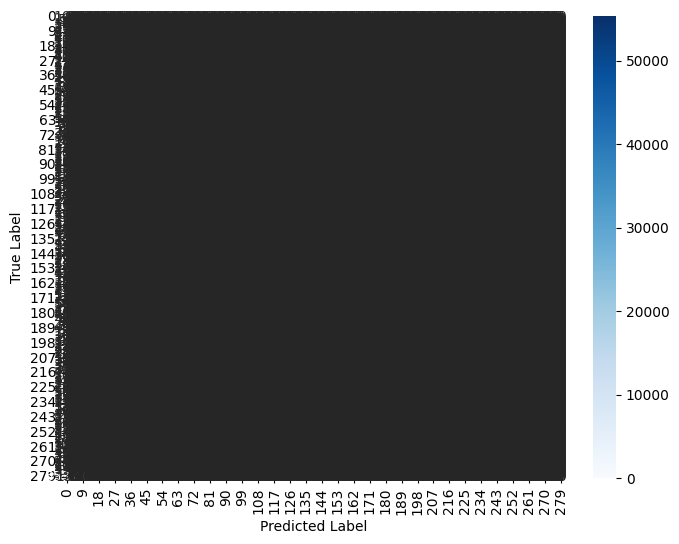

In [14]:
# Evaluar el modelo
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc}")
print(f"Validation Loss: {val_loss}")

# Generar predicciones y matriz de confusión
y_pred = (model.predict(validation_generator) > 0.5).astype("int32")
y_true = validation_generator.classes

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Mostrar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Graficar la precisión y la pérdida

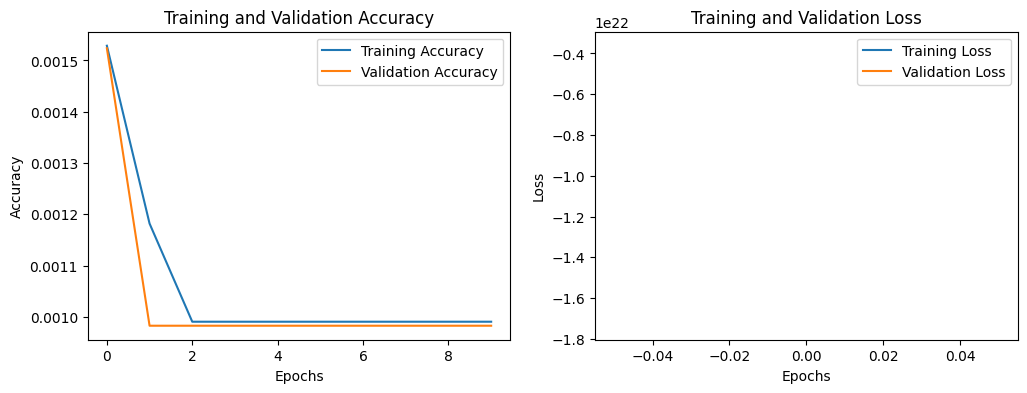

In [15]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


# Realizar predicciones con nuevas imágenes y evaluar el modelo

In [17]:
# Cargar algunas imágenes de prueba
test_img_path = "/content/sample_data/mnist_test.csv"

# Mostrar y hacer predicciones
for img_name in os.listdir(test_img_path)[:5]:
    img_path = os.path.join(test_img_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Maligno" if prediction > 0.5 else "Benigno"

    plt.imshow(img)
    plt.title(f"Predicción: {label}")
    plt.axis("off")
    plt.show()


NotADirectoryError: [Errno 20] Not a directory: '/content/sample_data/mnist_test.csv'

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Cargar algunas imágenes de prueba
test_img_path = "/content/sample_data/mnist_test.csv"

# Load the CSV file using pandas
df = pd.read_csv(test_img_path)

# Assuming the first column contains image data, replace with actual column name if different
# and the rest of the columns represent pixel values:
for index in range(5):  # Process the first 5 images
    image_data = df.iloc[index, 1:].values  # Get pixel values
    image_data = image_data.reshape(28, 28)  # Reshape to image dimensions (assuming 28x28 for MNIST)

    # Preprocess the image
    img_array = image_data.astype('float32') / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.expand_dims(img_array, axis=-1) # Add channel dimension (assuming grayscale)

    # Make the prediction
    prediction = model.predict(img_array)
    label = "Maligno" if prediction > 0.5 else "Benigno"

    # Display the image and prediction
    plt.imshow(image_data, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.title(f"Predicción: {label}")
    plt.axis("off")
    plt.show()

In [ ]:
import os

# Define la ruta a la carpeta 'mnis_test'
sample_data_dir = "/content/sample_data/mnist_test.csv"

# Obtén una lista de todos los archivos y carpetas dentro de 'sample_data'
contents = os.listdir(mnis_test)

# Imprime la lista de contenidos
print("Contenidos de la carpeta 'mnis_test':")
for item in contents:
    print(item)

In [18]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Cargar algunas imágenes de prueba
# Asumiendo que las imágenes están en una carpeta llamada 'test_images' dentro de 'sample_data'
test_img_dir = "/content/sample_data/mnist_test.csv"  # Reemplaza 'test_images' con el nombre real de la carpeta

# Mostrar y hacer predicciones
for img_name in os.listdir(test_img_dir)[:5]:
    img_path = os.path.join(test_img_dir, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Maligno" if prediction > 0.5 else "Benigno"

    plt.imshow(img)
    plt.title(f"Predicción: {label}")
    plt.axis("off")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/test_images'

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar algunas imágenes de prueba
# Assuming you have images in a directory called 'test_images'
# Change this path to your actual image directory
test_img_dir = "/content/sample_data/mnist_train_small.csv" # Updated: Now pointing to a directory

# Mostrar y hacer predicciones
for img_name in os.listdir(test_img_dir)[:5]: # Updated: Using the directory path
    img_path = os.path.join(test_img_dir, img_name) # Updated: Using the directory path
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Maligno" if prediction > 0.5 else "Benigno"

    plt.imshow(img)
    plt.title(f"Predicción: {label}")
    plt.axis("off")
    plt.show()

In [ ]:
import os

test_img_dir = "/content/sample_data/mnist_train_small.csv"

if os.path.exists(test_img_dir):
    print("La ruta existe.")
else:
    print("La ruta no existe. Verifica la ubicación de tus imágenes.")


In [ ]:
from google.colab import files

# Cargar imágenes en el directorio
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, os.path.join(test_img_dir, filename))
